/tmp/ipykernel_3916/1989849131.py:45: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


in shapes: (1, 30, 30, 30, 1) (3, 3, 3, 1, 1)
ConvDimensionNumbers(lhs_spec=(0, 4, 1, 2, 3), rhs_spec=(4, 3, 0, 1, 2), out_spec=(0, 4, 1, 2, 3))
out shape:  (1, 30, 30, 30, 1)


/tmp/ipykernel_3916/1989849131.py:50: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0.92, '3D conv output')

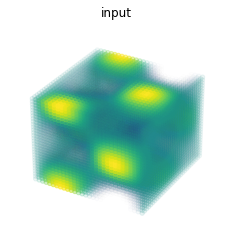

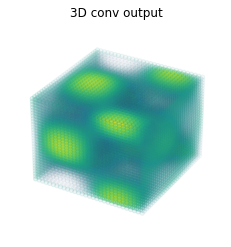

In [1]:
import matplotlib.pyplot as plt
from scipy import misc
import jax.scipy as jsp
from jax import random, lax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import figure


# Random 3D kernel - HWDIO layout
kernel = jnp.array([
  [[0, 0,  0], [0,  1,  0], [0,  0,   0]],
  [[0, -1, 0], [-1, 0, -1], [0,  -1,  0]], 
  [[0, 0,  0], [0,  1,  0], [0,  0,   0]]], 
  dtype=jnp.float32)[:, :, :, jnp.newaxis, jnp.newaxis]

# 3D data - NHWDC layout
data = jnp.zeros((1, 30, 30, 30, 1), dtype=jnp.float32)
x, y, z = np.mgrid[0:1:30j, 0:1:30j, 0:1:30j]
data += (jnp.sin(2*x*jnp.pi)*jnp.cos(2*y*jnp.pi)*jnp.cos(2*z*jnp.pi))[None,:,:,:,None]

print("in shapes:", data.shape, kernel.shape)
dn = lax.conv_dimension_numbers(data.shape, kernel.shape,
                                ('NHWDC', 'HWDIO', 'NHWDC'))
print(dn)

out = lax.conv_general_dilated(data,    # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1,1), # window strides
                               'SAME',  # padding mode
                               (1,1,1), # lhs/image dilation
                               (1,1,1), # rhs/kernel dilation
                               dn)      # dimension_numbers
print("out shape: ", out.shape)

# Make some simple 3d density plots:
from mpl_toolkits.mplot3d import Axes3D
def make_alpha(cmap):
  my_cmap = cmap(jnp.arange(cmap.N))
  my_cmap[:,-1] = jnp.linspace(0, 1, cmap.N)**3
  return mpl.colors.ListedColormap(my_cmap)
my_cmap = make_alpha(plt.cm.viridis)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=data.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('input')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=out.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('3D conv output')


(1280, 720)


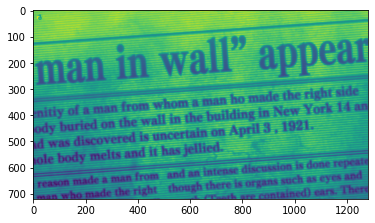

In [2]:
import PIL
#load a grayscaled image from data/mad1001.png
img = PIL.Image.open('data/3-000008375.png')
#get dimensions and print
print(img.size)
#convert to gray scale
img = img.convert('L')
#preview
imgplot = plt.imshow(img)
plt.show()

In [ ]:
#convert image to jax array
img = jnp.asarray(img)
#get the first few values jax array (note that the image is now a 3D array)
print(img[0,:])

In [92]:
import os
import glob

num_images = 180
start_frame = 8375

#get the first 100 sequential images from the data dir
img_paths = sorted(glob.glob('data/3-*.png'))[start_frame:start_frame+num_images]
#load all images into a single multi-channel array
for i, img_path in enumerate(img_paths):
    img = PIL.Image.open(img_path)
    img = img.convert('L')
    #resize to 100x100
    img = img.resize((100,100))
    img = jnp.asarray(img)
    #set set the left pixel of (num_images - i) to values of 0
    # img = img.at[:,:-(num_images-i)].set(0)
#add another dimension to the array for concatenation
    img = img[:,:,None]
    if img_paths[0] is img_path:
        images = img
    else:
        images = jnp.concatenate((images, img), axis=-1)

#print images dimensions
print(images.shape)

(100, 100, 180)


/tmp/ipykernel_3916/3365732173.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0.92, 'input')

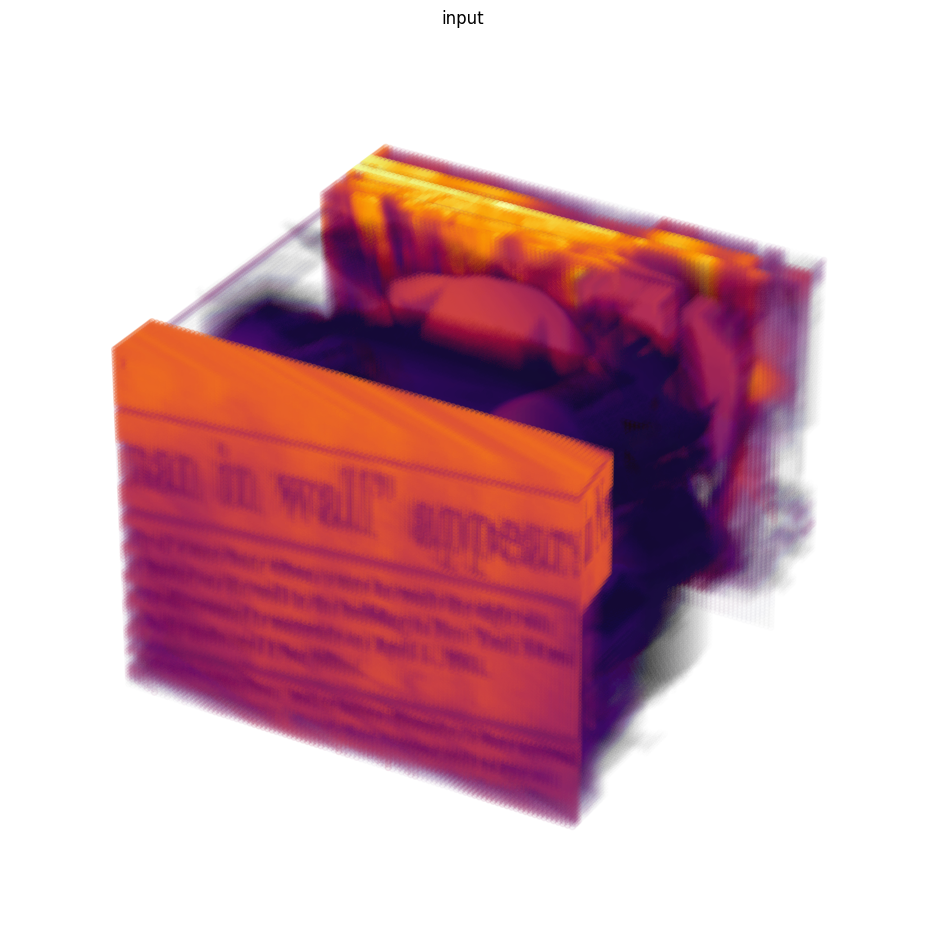

In [93]:
x, y, z = np.mgrid[0:images.shape[0], 0:images.shape[1], 0:images.shape[2]]
#rescale the data to be between 0 and 1
images = images/255
images = jnp.flip(images, axis=0)

def make_alpha(cmap):
  my_cmap = cmap(jnp.arange(cmap.N))
  my_cmap[:,-1] = jnp.linspace(0, 1, cmap.N)**2.5
  return mpl.colors.ListedColormap(my_cmap)

my_cmap = make_alpha(plt.cm.inferno)
fig = plt.figure()
fig.set_size_inches(12, 12)
fig.set_dpi(100)
ax = fig.gca(projection='3d')
#plot 3d scatter plot image tensor
ax.scatter(y.ravel(), z.ravel(), x.ravel(), c=images.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('input')

In [ ]:
#select only z position 50 of the video tensor
image_slice = images[:,:,160]
#undo invert
image_slice = jnp.flip(image_slice, axis=0)
#display the slice
plt.imshow(image_slice)

In [ ]:
#plot 3d scatter plot image tensor
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(12, 12)
fig.set_dpi(100)
ax.scatter(y.ravel(), z.ravel(), x.ravel(), c=images.ravel(), cmap=my_cmap)
ax.view_init(azim=40)
ax.axis('off')

In [ ]:
from matplotlib import animation
def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)

In [ ]:
ani.save('fig.gif', writer=animation.FFMpegWriter(fps=20))

In [3]:
import jax
jax.default_backend()


'cpu'

In [74]:
#lets do some actual work
#test image tensor augmentations
import tensorflow as tf


def rand_brightness(x):
  magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1]) - 0.5
  x = x + magnitude
  return x


def rand_saturation(x):
  magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1]) * 2
  x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
  x = (x - x_mean) * magnitude + x_mean
  return x


def rand_contrast(x):
  magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
  x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
  x = (x - x_mean) * magnitude + x_mean
  return x


def rand_translation(x, ratio=0.050):
  """Random translation."""
  batch_size = tf.shape(x)[0]
  image_size = tf.shape(x)[1:3]
  shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
  translation_x = tf.random.uniform([batch_size, 1],
                                    -shift[0],
                                    shift[0] + 1,
                                    dtype=tf.int32)
  translation_y = tf.random.uniform([batch_size, 1],
                                    -shift[1],
                                    shift[1] + 1,
                                    dtype=tf.int32)
  grid_x = tf.clip_by_value(
      tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) +
      translation_x + 1, 0, image_size[0] + 1)
  grid_y = tf.clip_by_value(
      tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) +
      translation_y + 1, 0, image_size[1] + 1)
  x = tf.gather_nd(
      tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]),
      tf.expand_dims(grid_x, -1),
      batch_dims=1)
  x = tf.transpose(
      tf.gather_nd(
          tf.pad(
              tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]),
          tf.expand_dims(grid_y, -1),
          batch_dims=1), [0, 2, 1, 3])
  return x


def rand_cutout(x, ratio=0.5):
  """Random Cutout."""
  batch_size = tf.shape(x)[0]
  image_size = tf.shape(x)[1:3]
  cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
  offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1],
                               maxval=image_size[0] + (1 - cutout_size[0] % 2),
                               dtype=tf.int32)
  offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1],
                               maxval=image_size[1] + (1 - cutout_size[1] % 2),
                               dtype=tf.int32)
  grid_batch, grid_x, grid_y = tf.meshgrid(
      tf.range(batch_size, dtype=tf.int32),
      tf.range(cutout_size[0], dtype=tf.int32),
      tf.range(cutout_size[1], dtype=tf.int32),
      indexing='ij')
  cutout_grid = tf.stack([
      grid_batch, grid_x + offset_x - cutout_size[0] // 2,
      grid_y + offset_y - cutout_size[1] // 2
  ],
                         axis=-1)
  mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
  cutout_grid = tf.maximum(cutout_grid, 0)
  cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1,
                                                   [1, 1, 1, 3]))
  mask = tf.maximum(
      1 - tf.scatter_nd(
          cutout_grid,
          tf.ones([batch_size, cutout_size[0], cutout_size[1]],
                  dtype=tf.float32), mask_shape), 0)
  x = x * tf.expand_dims(mask, axis=3)
  return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

def augment(x, policy='', channels_first=False):
  if policy:
    if channels_first:
      x = tf.transpose(x, [0, 2, 3, 1])
    for p in policy.split(','):
      for f in AUGMENT_FNS[p]:
        x = f(x)
    if channels_first:
      x = tf.transpose(x, [0, 3, 1, 2])
  return x


(100, 100, 180)


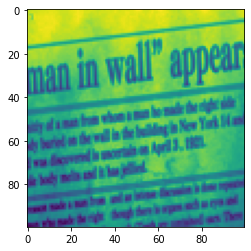

In [22]:
image_slice = images[:,:,0]
#undo invert
#display the slice
plt.imshow(image_slice)

print(images.shape)

(100, 100, 180)


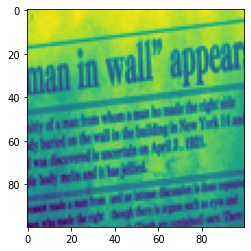

In [24]:
#feed images into the augmentation function
brightness_change = rand_brightness(images)

print(brightness_change.shape)

image_slice = brightness_change[:,:,0]
# #display the slice
plt.imshow(image_slice)

In [ ]:
#add a dimension at the front
images = tf.expand_dims(images, axis=0)
print(images.shape)

(1, 100, 100, 180)


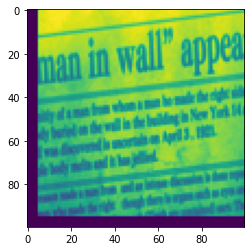

In [79]:
translation_change = rand_translation(images)

print(translation_change.shape)

#remove batch dimension
translation_change = tf.squeeze(translation_change, axis=0)
image_slice = translation_change[:,:,0]
# #display the slice
plt.imshow(image_slice)

In [ ]:
#convert tenorflow array to jax array
translation_change2 = translation_change.numpy()
#convert to jax array 
translation_change2 = np.flip(images, axis=0)

translation_change2 = translation_change2/255
#plot translation_change in 3d
x, y, z = np.mgrid[0:translation_change2.shape[0], 0:translation_change2.shape[1], 0:translation_change2.shape[2]]


my_cmap = make_alpha(plt.cm.inferno)
fig = plt.figure()
fig.set_size_inches(12, 12)
fig.set_dpi(100)
ax = fig.gca(projection='3d')
#plot 3d scatter plot image tensor
ax.scatter(tf.experimental.numpy.ravel(y), tf.experimental.numpy.ravel(z), tf.experimental.numpy.ravel(x), c=tf.experimental.numpy.ravel(translation_change2), cmap=my_cmap)
ax.axis('off')
ax.set_title('input')

In [ ]:
cutout_change = rand_cutout(images)
print(cutout_change.shape)

In [ ]:
#test data augmentations

from utils import data_augmentation

#